In [1]:
# 定义数据读取器
import cv2
import os
import random
import paddle
import paddle.fluid as fluid
import numpy as np
import visualdl
from visualdl import LogWriter
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Linear
from paddle.fluid.dygraph.base import to_variable
import matplotlib.pyplot as plt


DATADIR = 'PALM-Training400/PALM-Training400'
DATADIR2 = 'PALM-Validation400'
CSVFILE = 'PALM-Validation-GT/PM_Label_and_Fovea_Location.csv'

def transform_img(img):
    img = cv2.resize(img, (224, 224))
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    img = img / 255.
    img = img * 2.0 - 1.0
    return img


def data_loader(datadir, batch_size=5, mode = 'train'):
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            if name[0] == 'H' or name[0] == 'N':
                label = 0
            elif name[0] == 'P':
                label = 1
            else:
                raise('Not excepted file name')
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

def valid_data_loader(datadir, csvfile, batch_size=5, mode='valid'):
    filelists = open(csvfile).readlines()
    def reader():
        batch_imgs = []
        batch_labels = []
        for line in filelists[1:-1]:
            line = line.strip().split(',')
            name = line[1]
#             print('line:')
#             print(line)
#             print("line[2]:"+line[2])
            label = int(line[2])
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).astype('float32').reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

PLEASE USE OMP_NUM_THREADS WISELY.


In [13]:

class VGG(fluid.dygraph.Layer):
    def __init__(self):
        super(VGG,self).__init__()
        self.conv1_1 = Conv2D(num_channels=3,num_filters=64,filter_size=3, padding=1, act='relu')
        self.conv1_2 = Conv2D(num_channels=64,num_filters=64,filter_size=3, padding=1, act='relu')
        self.pool_1  = Pool2D(pool_stride=2, pool_size = 2, pool_type='max')

        self.conv2_1 = Conv2D(num_channels=64,num_filters=128,filter_size=3, padding=1, act='relu')
        self.conv2_2 = Conv2D(num_channels=128,num_filters=128,filter_size=3, padding=1, act='relu')
        self.pool_2  = Pool2D(pool_stride=2, pool_size = 2, pool_type='max')

        self.conv3_1 = Conv2D(num_channels=128,num_filters=256,filter_size=3, padding=1, act='relu')
        self.conv3_2 = Conv2D(num_channels=256,num_filters=256,filter_size=3, padding=1, act='relu')
        self.conv3_3 = Conv2D(num_channels=256,num_filters=256,filter_size=3, padding=1, act='relu')
        self.pool_3  = Pool2D(pool_stride=2, pool_size = 2, pool_type='max')

        self.conv4_1 = Conv2D(num_channels=256,num_filters=512,filter_size=3, padding=1, act='relu')
        self.conv4_2 = Conv2D(num_channels=512,num_filters=512,filter_size=3, padding=1, act='relu')
        self.conv4_3 = Conv2D(num_channels=512,num_filters=512,filter_size=3, padding=1, act='relu')
        self.pool_4  = Pool2D(pool_stride=2, pool_size = 2, pool_type='max')

        self.conv5_1 = Conv2D(num_channels=512,num_filters=512,filter_size=3, padding=1, act='relu')
        self.conv5_2 = Conv2D(num_channels=512,num_filters=512,filter_size=3, padding=1, act='relu')
        self.conv5_3 = Conv2D(num_channels=512,num_filters=512,filter_size=3, padding=1, act='relu')
        self.pool_5  = Pool2D(pool_stride=2, pool_size = 2, pool_type='max')

        self.fc1 = Linear(input_dim=512*7*7, output_dim=4096,act='relu')
        self.fc2= Linear(input_dim=4096, output_dim=4096,act='relu')
        self.fc3 = Linear(input_dim=4096, output_dim=1)
    def forward(self,x):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.pool_1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.pool_2(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.pool_3(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.pool_4(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        x = self.pool_5(x)
        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = fluid.layers.dropout(self.fc1(x), 0.5)  #0.5是drop的比率
        x = fluid.layers.dropout(self.fc2(x), 0.5)
        x = self.fc3(x)
        return x

In [14]:
x = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

start training ... 
epoch: 0, batch_id: 0, loss is: [0.8303824]
epoch: 0, batch_id: 10, loss is: [0.80453277]
epoch: 0, batch_id: 20, loss is: [0.6801781]
epoch: 0, batch_id: 30, loss is: [0.67894346]
epoch: 0, batch_id: 40, loss is: [0.58724314]
epoch: 0, batch_id: 50, loss is: [0.87257063]
epoch: 0, batch_id: 60, loss is: [0.50230867]
epoch: 0, batch_id: 70, loss is: [0.07188697]
[validation] accuracy/loss: 0.9074999690055847/0.3058038651943207


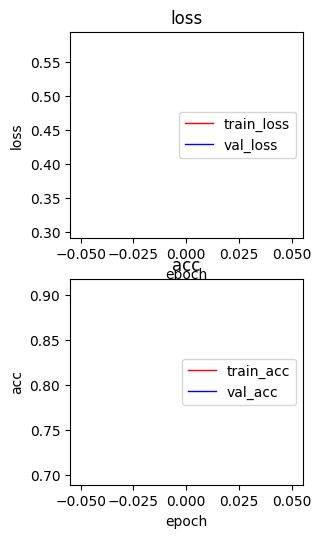

epoch: 1, batch_id: 0, loss is: [0.32992032]
epoch: 1, batch_id: 10, loss is: [0.33801925]
epoch: 1, batch_id: 20, loss is: [0.42190605]
epoch: 1, batch_id: 30, loss is: [0.04147197]
epoch: 1, batch_id: 40, loss is: [0.00570666]
epoch: 1, batch_id: 50, loss is: [0.48503816]
epoch: 1, batch_id: 60, loss is: [0.87267524]
epoch: 1, batch_id: 70, loss is: [0.24232419]
[validation] accuracy/loss: 0.875/0.3515368700027466


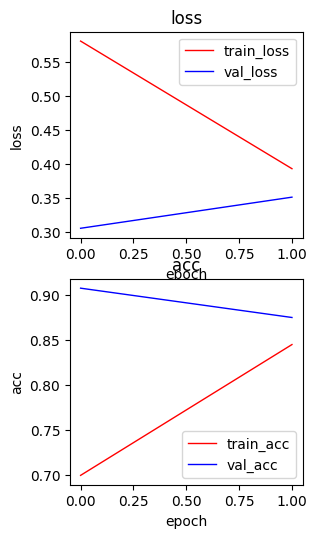

epoch: 2, batch_id: 0, loss is: [0.17805044]
epoch: 2, batch_id: 10, loss is: [0.13084488]
epoch: 2, batch_id: 20, loss is: [0.08981697]
epoch: 2, batch_id: 30, loss is: [0.6297467]
epoch: 2, batch_id: 40, loss is: [0.45074534]
epoch: 2, batch_id: 50, loss is: [0.11379497]
epoch: 2, batch_id: 60, loss is: [0.0008695]
epoch: 2, batch_id: 70, loss is: [0.10415469]
[validation] accuracy/loss: 0.9149999618530273/0.2403935194015503


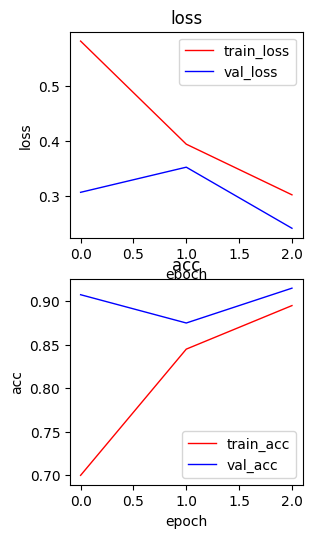

epoch: 3, batch_id: 0, loss is: [0.6859407]
epoch: 3, batch_id: 10, loss is: [0.7905268]
epoch: 3, batch_id: 20, loss is: [0.2023902]
epoch: 3, batch_id: 30, loss is: [0.13825998]
epoch: 3, batch_id: 40, loss is: [0.08979455]
epoch: 3, batch_id: 50, loss is: [0.14106041]
epoch: 3, batch_id: 60, loss is: [0.12166725]
epoch: 3, batch_id: 70, loss is: [0.03200675]
[validation] accuracy/loss: 0.9225000143051147/0.19379828870296478


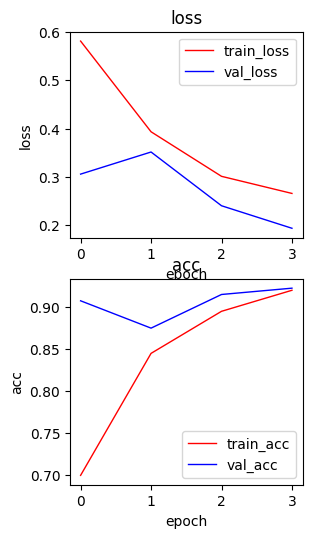

epoch: 4, batch_id: 0, loss is: [0.57788855]
epoch: 4, batch_id: 10, loss is: [0.1278562]
epoch: 4, batch_id: 20, loss is: [0.08420984]
epoch: 4, batch_id: 30, loss is: [0.15036377]
epoch: 4, batch_id: 40, loss is: [0.01484239]
epoch: 4, batch_id: 50, loss is: [0.23920211]
epoch: 4, batch_id: 60, loss is: [0.24731043]
epoch: 4, batch_id: 70, loss is: [0.29639655]
[validation] accuracy/loss: 0.925000011920929/0.1695965975522995


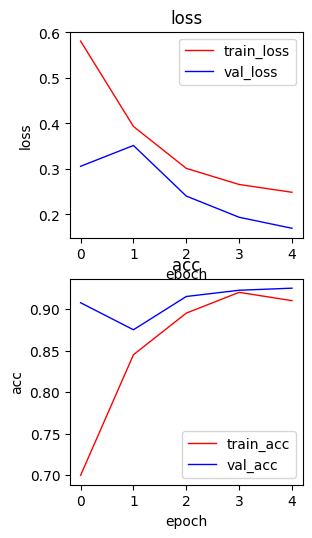

In [15]:
with fluid.dygraph.guard():
    model = VGG()
    print('start training ... ')
    model.train()
    epoch_num = 5
    # 定义优化器
    opt = fluid.optimizer.Momentum(learning_rate=0.001, momentum=0.9, parameter_list=model.parameters())
    # 定义数据读取器，训练数据读取器和验证数据读取器
    train_loader = data_loader(DATADIR, batch_size=5, mode='train')
    valid_loader = valid_data_loader(DATADIR2, CSVFILE)
    
    with LogWriter(logdir="./log/scalar_test/train") as writer:
        for epoch in range(epoch_num):
            x.append(epoch)
            train_accuracies = []
            train_loss = []
            for batch_id, data in enumerate(train_loader()):
                x_data, y_data = data
                img = fluid.dygraph.to_variable(x_data)
                label = fluid.dygraph.to_variable(y_data)
                logits = model(img)
                pred = fluid.layers.sigmoid(logits)
                pred2 = pred * (-1.0) + 1.0
                pred = fluid.layers.concat([pred2, pred], axis=1)
                
                #计算accuracy
                acc = fluid.layers.accuracy(pred, fluid.layers.cast(label, dtype='int64'))
                # 进行loss计算
                loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)  #loss的目的是让sigmoid(logits)去逼近label 所以在预测的时候预测值是sigmoid(logits) 
                avg_loss = fluid.layers.mean(loss)
                train_accuracies.append(acc.numpy())
                train_loss.append(loss.numpy())
                if batch_id % 10 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
                # 反向传播，更新权重，清除梯度
                avg_loss.backward()
                opt.minimize(avg_loss)
                model.clear_gradients()
            train_loss_list.append(np.mean(train_loss))
            train_acc_list.append(np.mean(train_accuracies)) 
            
            model.eval()
            accuracies = []
            losses = []
            for batch_id, data in enumerate(valid_loader()):
                x_data, y_data = data
                img = fluid.dygraph.to_variable(x_data)
                label = fluid.dygraph.to_variable(y_data)
                # 运行模型前向计算，得到预测值
                logits = model(img)
                # 二分类，sigmoid计算后的结果以0.5为阈值分两个类别
                # 计算sigmoid后的预测概率，进行loss计算
                pred = fluid.layers.sigmoid(logits)## 这个值大余）0.5就代表预测值为1
                loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)
                pred2 = pred * (-1.0) + 1.0
                # 得到两个类别的预测概率，并沿第一个维度级联
                pred = fluid.layers.concat([pred2, pred], axis=1) # [10，2]
                acc = fluid.layers.accuracy(pred, fluid.layers.cast(label, dtype='int64'))
                accuracies.append(acc.numpy())
                losses.append(loss.numpy())
            val_loss_list.append(np.mean(losses))
            val_acc_list.append(np.mean(accuracies))
            print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))
            
            writer.add_scalar(tag="acc",step=epoch,value = np.mean(accuracies))
            writer.add_scalar(tag="loss",step=epoch,value = np.mean(losses))
            model.train()
            plt.figure(figsize=(12, 6))
            
            # Plot loss
            plt.subplot(1, 2, 1)
            plt.plot(x, train_loss_list, 'r', label='Train Loss')
            plt.plot(x, val_loss_list, 'b', label='Validation Loss')
            plt.title("Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()

            # Plot accuracy
            plt.subplot(1, 2, 2)
            plt.plot(x, train_acc_list, 'r', label='Train Accuracy')
            plt.plot(x, val_acc_list, 'b', label='Validation Accuracy')
            plt.title("Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.legend()

            plt.tight_layout()
            plt.show()
            plt.pause(0.1)
    # save params of model
    fluid.save_dygraph(model.state_dict(), 'palm')
    # save optimizer state
    fluid.save_dygraph(opt.state_dict(), 'palm')
    
# 关闭日志写入器
train_summary_writer.close()

In [16]:
from visualdl.server import app
app.run("./log/scalar_test/train",
        host="127.0.0.1",
        port=6006,
        cache_timeout=20,            
        language=None,            
        public_path=None,    
        api_only=False,             
        open_browser=False)

/root/miniconda3/lib/python3.8/site-packages/flask_babel/__init__.py:225: DeprecationWarning: 'locked_cached_property' is deprecated and will be removed in Flask 2.4. Use a lock inside the decorated function if locking is needed.
  def domain_instance(self):


4791

VisualDL 2.5.3
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.


In [6]:
valid_loader = valid_data_loader(DATADIR2, CSVFILE)
model.eval()
accuracies = []
losses = []
with fluid.dygraph.guard():
    for batch_id, data in enumerate(valid_loader()):
        x_data, y_data = data
        img = fluid.dygraph.to_variable(x_data)
        label = fluid.dygraph.to_variable(y_data)
        # 运行模型前向计算，得到预测值
        logits = model(img)
        pred = fluid.layers.sigmoid(logits)
        loss = fluid.layers.sigmoid_cross_entropy_with_logits(logits, label)
        avg_loss = fluid.layers.mean(loss)
        # 计算预测概率小于0.5的类别
        pred2 = pred * (-1.0) + 1.0
        # 得到两个类别的预测概率，并沿第一个维度级联
        pred = fluid.layers.concat([pred2, pred], axis=1)
        acc = fluid.layers.accuracy(pred, fluid.layers.cast(label, dtype='int64'))
        accuracies.append(acc.numpy())
        losses.append(loss.numpy())
print("[validation] accuracy/loss: {}/{}".format(np.mean(accuracies), np.mean(losses)))

[validation] accuracy/loss: 0.9200000762939453/0.19351202249526978
